In [3]:
import pandas as pd
import numpy as np
DATA_DIR = "./"

**CSV files**

In [6]:
date_cols = [
    "order_purchase_timestamp",
    "order_approved_at",
    "order_delivered_carrier_date",
    "order_delivered_customer_date",
    "order_estimated_delivery_date",
]

orders   = pd.read_csv(DATA_DIR + "olist_orders_dataset.csv", parse_dates=date_cols, low_memory=False)
items    = pd.read_csv(DATA_DIR + "olist_order_items_dataset.csv", low_memory=False)
customers= pd.read_csv(DATA_DIR + "olist_customers_dataset.csv", low_memory=False)
products = pd.read_csv(DATA_DIR + "olist_products_dataset.csv", low_memory=False)
sellers  = pd.read_csv(DATA_DIR + "olist_sellers_dataset.csv", low_memory=False)
payments = pd.read_csv(DATA_DIR + "olist_order_payments_dataset.csv", low_memory=False)
reviews  = pd.read_csv(DATA_DIR + "olist_order_reviews_dataset.csv",
                       parse_dates=["review_creation_date","review_answer_timestamp"], low_memory=False)
trans    = pd.read_csv(DATA_DIR + "product_category_name_translation.csv", low_memory=False)

orders.head(), items.head()

(                           order_id                       customer_id  \
 0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
 1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
 2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
 3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
 4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   
 
   order_status order_purchase_timestamp   order_approved_at  \
 0    delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   
 1    delivered      2018-07-24 20:41:37 2018-07-26 03:24:27   
 2    delivered      2018-08-08 08:38:49 2018-08-08 08:55:23   
 3    delivered      2017-11-18 19:28:06 2017-11-18 19:45:59   
 4    delivered      2018-02-13 21:18:39 2018-02-13 22:20:29   
 
   order_delivered_carrier_date order_delivered_customer_date  \
 0          2017-10-04 19:55:00           2017-10-10 21:25:13   
 1          2018-07-26 14:31:00       

**Translate product categories to English**

In [7]:
products = products.merge(trans, how="left", on="product_category_name")
products["category_en"] = products["product_category_name_english"].fillna(products["product_category_name"])
products = products.drop(columns=["product_category_name_english"])

In [8]:
# sum payments per order and join payment types found on the order
pay_sum = payments.groupby("order_id", as_index=False).agg(
    payment_value=("payment_value","sum"),
    payment_types=("payment_type", lambda x: ", ".join(sorted(set(x))))
)

# average review per order
rev_mean = reviews.groupby("order_id", as_index=False).agg(review_score=("review_score","mean"))

# join step by step
df = (items
      .merge(orders, on="order_id", how="left")
      .merge(customers, on="customer_id", how="left")
      .merge(products[["product_id","category_en"]], on="product_id", how="left")
      .merge(sellers, on="seller_id", how="left", suffixes=("","_seller"))
      .merge(pay_sum, on="order_id", how="left")
      .merge(rev_mean, on="order_id", how="left")
     )

# keep only meaningful order statuses for sales
df = df[df["order_status"].isin(["delivered","shipped","invoiced","approved","processing","created"])]

# add time keys
df["year_month"] = df["order_purchase_timestamp"].dt.to_period("M").astype(str)

# money fields per item
df["item_revenue"] = df["price"]
df["freight"] = df["freight_value"]

df.shape

(112101, 28)

In [9]:
# percent missing by column
na_rate = df.isna().mean().sort_values(ascending=False).round(3)
na_rate.head(15)

,0
order_delivered_customer_date,0.017
category_en,0.014
review_score,0.008
order_delivered_carrier_date,0.006
order_approved_at,0.000
payment_types,0.000
payment_value,0.000
shipping_limit_date,0.000
seller_id,0.000
product_id,0.000


In [10]:
orders_revenue = df.groupby("order_id", as_index=False).agg(
    order_revenue=("item_revenue","sum"),
    order_freight=("freight","sum")
)

kpis = {
    "Total Orders": df["order_id"].nunique(),
    "Total Items": len(df),
    "Gross Revenue": df["item_revenue"].sum(),
    "Freight Cost": df["freight"].sum(),
}
kpis["Net Revenue"] = kpis["Gross Revenue"] - kpis["Freight Cost"]
kpis["Average Order Value"] = orders_revenue["order_revenue"].mean()

kpis

{'Total Orders': 98199,
 'Total Items': 112101,
 'Gross Revenue': np.float64(13494400.740000002),
 'Freight Cost': np.float64(2241126.29),
 'Net Revenue': np.float64(11253274.450000003),
 'Average Order Value': np.float64(137.418922188617)}

In [11]:
trend = df.groupby("year_month", as_index=False).agg(
    orders=("order_id","nunique"),
    revenue=("item_revenue","sum")
).sort_values("year_month")

trend.head()


,year_month,orders,revenue
0,2016-09,2,207.86
1,2016-10,290,44507.30
2,2016-12,1,10.90
3,2017-01,787,120098.27
4,2017-02,1718,244959.35


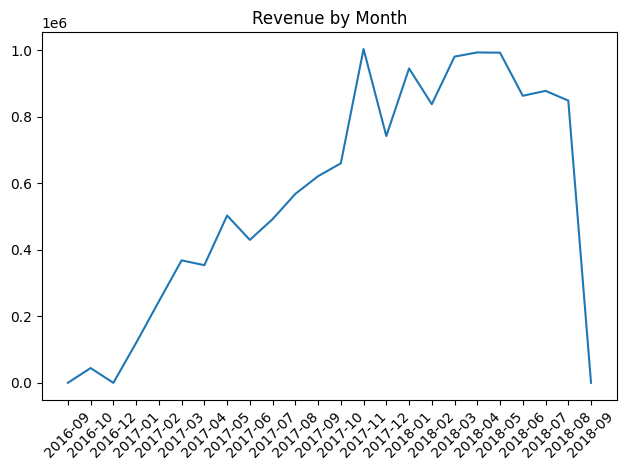

In [12]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(trend["year_month"], trend["revenue"])
plt.title("Revenue by Month")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [13]:
by_cat = df.groupby("category_en", as_index=False).agg(
    orders=("order_id","nunique"),
    items=("product_id","count"),
    revenue=("item_revenue","sum"),
    avg_review=("review_score","mean")
).sort_values("revenue", ascending=False)

by_cat.head(10)

,category_en,orders,items,revenue,avg_review
43,health_beauty,8800,9634,1255695.13,4.150318
72,watches_gifts,5604,5970,1198185.21,4.027703
7,bed_bath_table,9399,11097,1035964.06,3.901177
67,sports_leisure,7673,8590,979740.92,4.122436
15,computers_accessories,6654,7781,904322.02,3.947467
39,furniture_decor,6425,8298,727465.05,3.919355
49,housewares,5847,6915,626825.80,4.072770
20,cool_stuff,3616,3779,620770.49,4.157551
5,auto,3872,4204,586585.73,4.078587
42,garden_tools,3505,4328,481009.94,4.056215


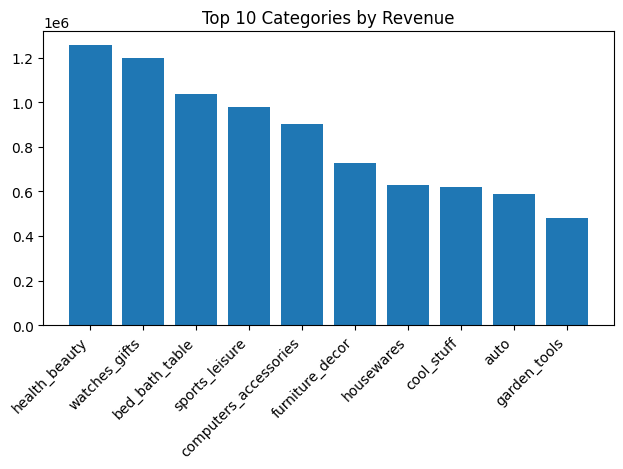

In [14]:
topc = by_cat.head(10)
plt.figure()
plt.bar(topc["category_en"], topc["revenue"])
plt.title("Top 10 Categories by Revenue")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [15]:
by_state = df.groupby("customer_state", as_index=False).agg(
    orders=("order_id","nunique"),
    revenue=("item_revenue","sum")
).sort_values("revenue", ascending=False)

by_state.head(10)


,customer_state,orders,revenue
25,SP,41125,5163867.22
18,RJ,12697,1811623.42
10,MG,11496,1573508.20
22,RS,5415,742559.78
17,PR,4982,676883.06
23,SC,3599,518578.28
4,BA,3344,507108.83
6,DF,2120,300886.45
8,GO,1998,287870.46
7,ES,2018,273532.13


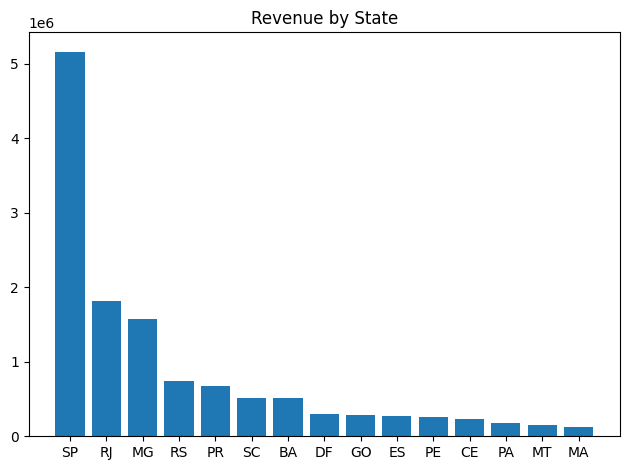

In [16]:
tops = by_state.head(15)
plt.figure()
plt.bar(tops["customer_state"], tops["revenue"])
plt.title("Revenue by State")
plt.tight_layout()
plt.show()


**Delivery speed and on time rate**

In [17]:
# time deltas in days
df["days_to_deliver"] = (df["order_delivered_customer_date"] - df["order_purchase_timestamp"]).dt.days
df["days_to_ship"] = (df["order_delivered_carrier_date"] - df["order_approved_at"]).dt.days
df["on_time"] = df["order_delivered_customer_date"] <= df["order_estimated_delivery_date"]

delivery_summary = df.groupby("seller_id", as_index=False).agg(
    orders=("order_id","nunique"),
    avg_days_ship=("days_to_ship","mean"),
    avg_days_deliver=("days_to_deliver","mean"),
    on_time_rate=("on_time","mean"),
    avg_review=("review_score","mean")
).sort_values("avg_days_deliver")

delivery_summary.head(10)


,seller_id,orders,avg_days_ship,avg_days_deliver,on_time_rate,avg_review
514,2c00c85d30361cd2ced2969cffbbffa3,1,0.0,1.0,1.0,5.0
1424,751e274377499a8503fd6243ad9c56f6,1,0.0,1.0,1.0,5.0
1350,702835e4b785b67a084280efca355756,1,0.0,1.0,1.0,5.0
1245,674207551483fec113276b67b0d871ff,1,0.0,1.0,1.0,5.0
2903,f3511c85f59f8dec53d140501ee8e7a8,1,0.0,1.0,1.0,5.0
1220,6561d6bf844e464b4019442692b40e02,1,0.0,1.0,1.0,5.0
227,139157dd4daa45c25b0807ffff348363,1,0.0,1.0,1.0,4.0
1142,5e063e85d44b0f5c3e6ec3131103a57e,1,0.0,1.0,1.0,5.0
1820,96f7c797de9ca20efbe14545bed63eec,1,0.0,1.0,1.0,1.0
1402,734def04b237117a09321dd6d8f3f2a2,2,0.5,1.5,1.0,5.0


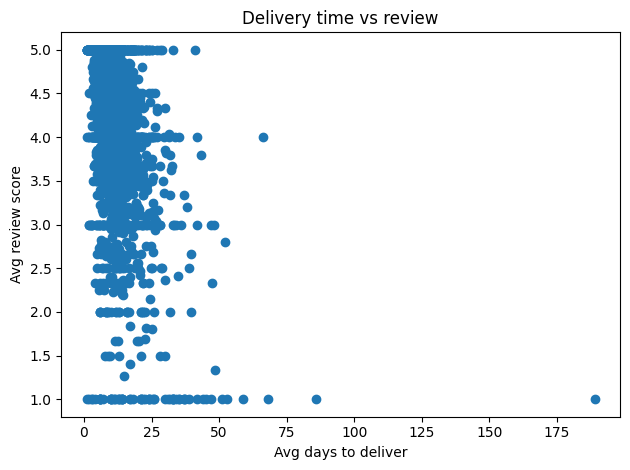

In [18]:
plt.figure()
plt.scatter(delivery_summary["avg_days_deliver"], delivery_summary["avg_review"])
plt.xlabel("Avg days to deliver")
plt.ylabel("Avg review score")
plt.title("Delivery time vs review")
plt.tight_layout()
plt.show()

**Payment split and review health**

In [19]:
pay_share = payments["payment_type"].value_counts(normalize=True).rename_axis("payment_type").reset_index(name="share")
pay_share

,payment_type,share
0,credit_card,0.739224
1,boleto,0.190440
2,voucher,0.055590
3,debit_card,0.014718
4,not_defined,0.000029


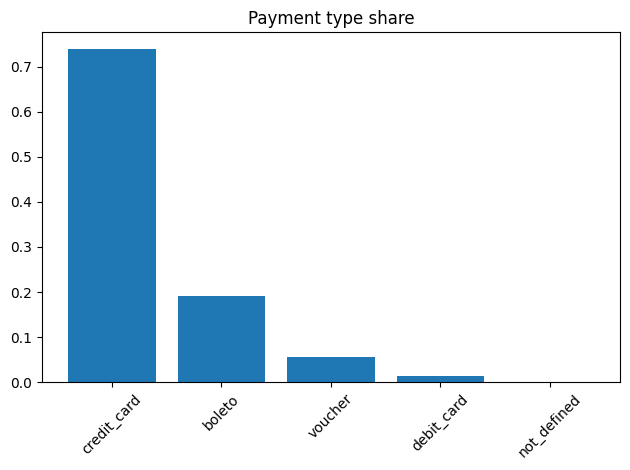

In [20]:
plt.figure()
plt.bar(pay_share["payment_type"], pay_share["share"])
plt.title("Payment type share")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [21]:
rev_by_cat = df.groupby("category_en", as_index=False).agg(avg_review=("review_score","mean")).sort_values("avg_review", ascending=False)
rev_by_cat.head(10)


,category_en,avg_review
11,cds_dvds_musicals,4.642857
29,fashion_childrens_clothes,4.500000
8,books_general_interest,4.483395
22,costruction_tools_tools,4.444444
35,flowers,4.419355
9,books_imported,4.400000
10,books_technical,4.363636
53,luggage_accessories,4.327491
37,food_drink,4.324275
66,small_appliances_home_oven_and_coffee,4.302632


**Customer RFM**

In [22]:
# use customer_unique_id to keep the same person across addresses
cust_orders = df.groupby(["customer_unique_id","order_id"], as_index=False).agg(
    order_date=("order_purchase_timestamp","max"),
    order_value=("item_revenue","sum")
)

last_date = cust_orders["order_date"].max()

rfm = cust_orders.groupby("customer_unique_id", as_index=False).agg(
    recency_days=("order_date", lambda x: (last_date - x.max()).days),
    frequency=("order_id","count"),
    monetary=("order_value","sum")
)

# scores from 1 to 5
# use rank to avoid ties issues
rfm["R_score"] = pd.qcut((-rfm["recency_days"]).rank(method="first"), 5, labels=[1,2,3,4,5])
rfm["F_score"] = pd.qcut((rfm["frequency"]).rank(method="first"), 5, labels=[1,2,3,4,5])
rfm["M_score"] = pd.qcut((rfm["monetary"]).rank(method="first"), 5, labels=[1,2,3,4,5])

rfm[["R_score","F_score","M_score"]] = rfm[["R_score","F_score","M_score"]].astype(int)
rfm["RFM_total"] = rfm[["R_score","F_score","M_score"]].sum(axis=1)

def label_segment(score):
    if score >= 13:
        return "Champions"
    if score >= 10:
        return "Loyal"
    if score >= 7:
        return "Potential"
    return "At Risk"

rfm["segment"] = rfm["RFM_total"].apply(label_segment)
rfm.head()


,customer_unique_id,recency_days,frequency,monetary,R_score,F_score,M_score,RFM_total,segment
0,0000366f3b9a7992bf8c76cfdf3221e2,115,1,129.90,4,1,4,9,Potential
1,0000b849f77a49e4a4ce2b2a4ca5be3f,118,1,18.90,4,1,1,6,At Risk
2,0000f46a3911fa3c0805444483337064,541,1,69.00,1,1,2,4,At Risk
3,0000f6ccb0745a6a4b88665a16c9f078,325,1,25.99,2,1,1,4,At Risk
4,0004aac84e0df4da2b147fca70cf8255,292,1,180.00,2,1,5,8,Potential


In [23]:
rfm_summary = rfm.groupby("segment", as_index=False).agg(
    customers=("customer_unique_id","count"),
    avg_monetary=("monetary","mean")
).sort_values("customers", ascending=False)

rfm_summary


,segment,customers,avg_monetary
3,Potential,39079,109.466994
2,Loyal,32106,187.897704
0,At Risk,15688,48.823261
1,Champions,8110,298.145136


In [24]:
df.to_csv("olist_clean_items_orders.csv", index=False)           # main joined table
trend.to_csv("trend_monthly.csv", index=False)
by_cat.to_csv("category_performance.csv", index=False)
by_state.to_csv("state_performance.csv", index=False)
delivery_summary.to_csv("seller_delivery_performance.csv", index=False)
pay_share.to_csv("payment_share.csv", index=False)
rfm.to_csv("rfm_customers.csv", index=False)
rfm_summary.to_csv("rfm_summary.csv", index=False)


In [25]:
df.to_csv("olist_clean_items_orders.csv", index=False)           # main joined table
trend.to_csv("trend_monthly.csv", index=False)
by_cat.to_csv("category_performance.csv", index=False)
by_state.to_csv("state_performance.csv", index=False)
delivery_summary.to_csv("seller_delivery_performance.csv", index=False)
pay_share.to_csv("payment_share.csv", index=False)
rfm.to_csv("rfm_customers.csv", index=False)
rfm_summary.to_csv("rfm_summary.csv", index=False)
